# Bandit Sequence Design

Design 60 6-base RBS sequences based on the bandit recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [3]:
df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 6)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

## Construct feature spaces

would be 'AAGT' + 6-base + 'GGA' 

@Maciej: to determine the seq other than the 6-base.

In [6]:
# create all combos
from itertools import product
import math

combos = []
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'AAGT'
pos_design = 'GGA'

for combo in product(char_sets, repeat= design_len):
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [7]:
todesign_data = np.asarray(list(zip(combos, labels)))

## Recommendations with GPUCB

Cannot find idx for  0001100010000010001010000010001000011000100001000010
Cannot find idx for  0001100010000010001010000010001000101000100001000010
Cannot find idx for  0001100010000010001010000010001010001000100001000010
Cannot find idx for  0001100010000010001010000100001000011000100001000010
Cannot find idx for  0001100010000010001010000100001000101000100001000010
Cannot find idx for  0001100010000010001010000100001010001000100001000010
Cannot find idx for  0001100010000010001010001000001000011000100001000010
Cannot find idx for  0001100010000010001010001000001000101000100001000010
Cannot find idx for  0001100010000010001010001000001010001000100001000010
Cannot find idx for  0100100000010100000110001000001000100010001000100010
Cannot find idx for  0100100000010100000110001000001000100010001000100100
Cannot find idx for  0100100000010100000110001000001000100010001000101000
Cannot find idx for  0100100000010100000110001000001000100010010000100010
Cannot find idx for  01001000000101000

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


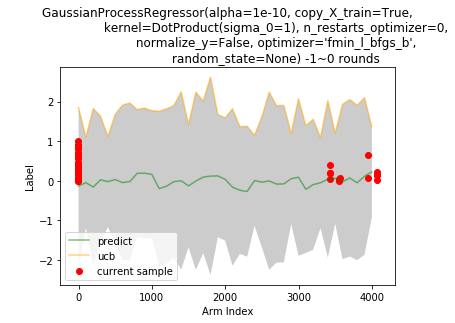

In [9]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(data, 'onehot')
new_env = Rewards_env(todesign_data, 'onehot')
agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = DotProduct()))
rec_arms = agent.play(label_avaiable = False)

## Convert to RBS seq

In [29]:
onehot_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]

In [31]:
onehot_dict = {'1000': 'A',
               '0100': 'C',
               '0010': 'G',
               '0001': 'T'}

rbs_seqs = []

for seq in onehot_seqs:
    rbs_seq = []
    for i in range(int(len(seq)/4)):
        start = i * 4
        end = start + 4
        s = seq[start:end]
        rbs_seq.append(onehot_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)
    
rbs_seqs

['AAGTGAGACTGGA',
 'AAGTGAGTCTGGA',
 'AAGTGACTCTGGA',
 'AAGTGACACTGGA',
 'AAGTGATCCTGGA',
 'AAGTGCTTTAGGA',
 'AAGTGCTATAGGA',
 'AAGTGCGACAGGA',
 'AAGTGCGTCAGGA',
 'AAGTGGTACAGGA',
 'AAGTGGTTCAGGA',
 'AAGTTATACTGGA',
 'AAGTTATTCTGGA',
 'AAGTGATAGTGGA',
 'AAGTGATTGTGGA',
 'AAGTGCCACAGGA',
 'AAGTGCCTCAGGA',
 'AAGTGCTGCTGGA',
 'AAGTGCTCCAGGA',
 'AAGTAATTCTGGA',
 'AAGTAATACTGGA',
 'AAGTGATTCGGGA',
 'AAGTGATACGGGA',
 'AAGTTCTACAGGA',
 'AAGTTCTTCAGGA',
 'AAGTGCTTGAGGA',
 'AAGTGCTAGAGGA',
 'AAGTGCTAATGGA',
 'AAGTGCTTATGGA',
 'AAGTACTACAGGA',
 'AAGTACTTCAGGA',
 'AAGTCCTTCTGGA',
 'AAGTCCTACTGGA',
 'AAGTGCAACTGGA',
 'AAGTGCATCTGGA',
 'AAGTGCTTTTGGA',
 'AAGTGCTATTGGA',
 'AAGTGCGTCTGGA',
 'AAGTGCGACTGGA',
 'AAGTGGTTCTGGA',
 'AAGTGGTACTGGA',
 'AAGTGCCTCTGGA',
 'AAGTGCCACTGGA',
 'AAGTTCTTCTGGA',
 'AAGTTCTACTGGA',
 'AAGTGATACAGGA',
 'AAGTGATTCAGGA',
 'AAGTGCTCCTGGA',
 'AAGTGCTAGTGGA',
 'AAGTGCTTGTGGA',
 'AAGTACTACTGGA',
 'AAGTACTTCTGGA',
 'AAGTGCTTCGGGA',
 'AAGTGCTACGGGA',
 'AAGTGATACTGGA',
 'AAGTGATT